Build a RAG App - Part 1

In [69]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [70]:
groq_api_key = os.getenv("GROQ_API_KEY")
HF_TOKEN = os.getenv("HF_TOKEN")

In [71]:
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [72]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [73]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name="gemma2-9b-it")

In [74]:
from typing_extensions import List, TypedDict
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [75]:
loader = WebBaseLoader(
    web_paths = ("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs = dict(
        parse_only = bs4.SoupStrainer(
            class_ = ("post-content", "post-title", "post-header")
        )
    )
)

In [76]:
docs = loader.load()

In [77]:
docs

[Document(page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final re

In [78]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
chunks = text_splitter.split_documents(docs)
len(chunks)

63

In [79]:
from langchain_community.vectorstores import InMemoryVectorStore

In [80]:
vectorstore = InMemoryVectorStore(embeddings)

In [81]:
vectorstore

In [18]:
vectorstore.add_documents(documents=chunks)

['762867e9-0551-4b57-975c-5958c0e236c7',
 'fb3eea05-0dfa-48d4-9d30-1f163c5746e7',
 'c88c2223-5635-423c-8a9f-fe26a27d23b2',
 '0641c329-f279-44ad-943d-cf56ad779537',
 'da759861-8387-4574-aadb-c416a899a1e3',
 'eb3bb30c-c9c6-42c9-b782-4f972fad3d76',
 '823e4f29-132f-4c9a-90b9-918a62316b37',
 'cd2669ae-9143-4245-9223-9a47af24d40e',
 'df67c2ec-ea32-4911-b7f5-09a89521409d',
 '9691bca6-4940-4b18-93e6-4fa14d350bda',
 '9d07a244-9be0-46d0-b54a-d0c2b80a8df0',
 'a8b83260-5788-47d3-b342-50658b3c681a',
 '318bfeee-9c34-4374-8c8d-d6243e1b022e',
 '29c1783c-a638-4b9e-a42b-166aea32fe38',
 'd4a81566-a6f6-47ce-933b-ed7460238b9b',
 '52140928-7369-4508-90f0-2d39a31ac463',
 'd196dd3d-e32f-4726-bf1c-999aeed48ba4',
 'e3fcecc2-5065-441a-8e4c-871602f6639e',
 'bbe60acb-8716-4bf4-9ef1-e428ddf2c754',
 '6be49845-a702-4a13-a9c4-9ff51e35e917',
 '24dd6e7f-5bc3-439b-8ec9-3c68cf77caf5',
 'bcba37cc-de51-4d88-b1cf-6d9620e36505',
 'f57cbfb4-1af7-4fdb-b9f8-452622655c38',
 '2b92b20e-488f-4094-9ccf-5e91ea27fe01',
 '17c2b2cb-00e9-

In [32]:
from langchain.prompts import PromptTemplate

In [33]:
template = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""

prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=template
)

State of the Application

In [34]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

Application Steps

In [35]:
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [36]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question":state["question"], "context":docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [37]:
from langgraph.graph import START, StateGraph, END

In [38]:
graph_builder = StateGraph(State)

In [39]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.set_entry_point("retrieve")

graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

In [40]:
graph = graph_builder.compile()

In [41]:
response = graph.invoke({"question":"What is Task Decomposition?"})

In [42]:
response

{'question': 'What is Task Decomposition?',
 'context': [Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in c

In [43]:
response["answer"]

'Task decomposition is the process of breaking down a complex task into smaller, more manageable subtasks.  LLMs can be prompted to perform task decomposition, or it can be done using task-specific instructions or human input. This helps make complex tasks more approachable and solvable. \n\n\n'

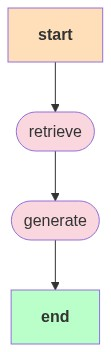

In [44]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

##### Stream Steps

In [45]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not i

##### Query Analysis

In [82]:
len(chunks)

63

In [83]:
total_documents = len(chunks)
third = total_documents // 3

for i, document in enumerate(chunks):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


chunks[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

In [84]:
chunks[30].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'middle'}

In [85]:
chunks[62].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'end'}

In [86]:
# vector_store = InMemoryVectorStore(embeddings)
vectorstore.add_documents(chunks)

['1770683c-ad0f-47c9-9898-9b9e6e3b92d5',
 'e75aca46-35b6-4aeb-b63f-bf803da493a1',
 'b6d2bbcc-255b-41a9-9f1f-3a0ce6ac1665',
 '34fa2134-2328-4836-ad1f-2f727fbdec03',
 'b670814b-3c11-42e6-af71-6deea57fa69b',
 '672cfd84-5e76-4d9a-a37e-f0cbf89492d4',
 '66f5387d-d759-41bb-b9e5-e0525136fc05',
 '1a541d1b-244f-41da-a27f-c30f9d45dcbd',
 '9aea2b61-b2bc-467c-9323-5dc6fcc47d9e',
 '0f88ec93-df81-4253-860c-7f4dd8d6b231',
 '05ee5fde-f926-491e-a993-12d5541cd454',
 'ca5078e8-ae7e-40af-a763-a65a4be1d155',
 '2457af2b-da8b-43e3-b024-4f0711d76f22',
 '6f0d607f-55fd-4c57-9a69-0047809741a2',
 'e6c413b5-d131-489e-a5af-45f4bf5e2a8d',
 '4bece304-68b8-4145-8a0a-a1ed0e88a573',
 '62353a36-6bcf-4870-bc14-dc9e69117b89',
 'd1d4e611-d6bf-4a81-b48f-dbed5851dab2',
 '859d379d-b0d9-460b-8c1c-5a430e334a71',
 'dff244aa-ccd3-47c4-ad00-c41ff5dcb764',
 '3b5b1b53-90c0-4c9c-ad55-249e9cfde2f8',
 '7e374605-a839-47da-9e66-e1cf76d3bef6',
 'c93fdf3c-8f9e-467b-acdc-6d9711972bfd',
 'ca458b77-7417-456a-a3da-d493fed3b6c5',
 'eb78c30f-1a2d-

In [87]:
from typing import Literal
from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

query will now have 2 parameters from Search (query, section)

In [88]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

In [89]:
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

In [90]:
def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vectorstore.similarity_search(query["query"], 
                    filter = lambda doc: doc.metadata.get("section")==query["section"])
    return {"context": retrieved_docs}

In [91]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [92]:
graph_builder = StateGraph(State)

In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("analyze_query", analyze_query)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "analyze_query")
graph_builder.add_edge("analyze_query", "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)


In [98]:
graph = graph_builder.compile()

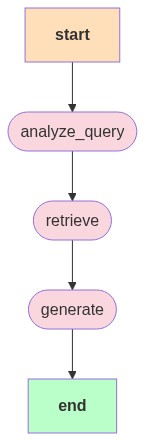

In [99]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [133]:
import json
from langchain_core.output_parsers import JsonOutputParser

In [138]:
parser = JsonOutputParser()

prompt = PromptTemplate.from_template("""
Extract a JSON object with this schema:

{{
  "query": "<search query>",
  "section": "beginning | middle | end"
}}

Only return JSON. No explanation.
Question: {question}
""")

# Use a simple chain
chain = prompt | llm | parser

In [139]:
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = prompt | llm | JsonOutputParser()
    query = structured_llm.invoke({"question": state["question"]})
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vectorstore.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [136]:
from langgraph.graph import StateGraph, END, START

graph_builder = StateGraph(State)

graph_builder.add_node("analyze_query", analyze_query)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "analyze_query")
graph_builder.add_edge("analyze_query", "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()


In [137]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'What does the end of the post say about Task Decomposition?', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an